# Classifying Digits 0 to 4 of MNIST 

The goal of this project is to build and train a deep feed forward neural network to classify the 
first five digits, 0 to 4, of the MNIST dataset. 

Training is done using the low-level API of the **Tensorflow** framework. Steps involved include:
* Download and preprocess MNIST dataset
* Build DNN and train on dataset
* Evaluate test accuracy of model and make some predictions
* Tweak model to see if we achieve better results

#### Import libraries we are going to use

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from datetime import datetime
%matplotlib inline

#### Download and preprocess MNIST dataset

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


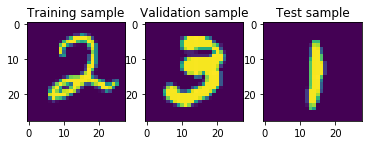

In [2]:
#load dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/tmp/data/')

valid_size = 5000

#extract digits 0 to 4 of training dataset
train_index_0_4 = np.nonzero(mnist.train.labels <= 4)[0]
mnist_train_images_0_4 = mnist.train.images[train_index_0_4]
mnist_train_labels_0_4 = mnist.train.labels[train_index_0_4]

#extract digits 0 to 4 of validation dataset
valid_index_0_4 = np.nonzero(mnist.validation.labels <= 4)[0]
mnist_valid_images_0_4 = mnist.validation.images[valid_index_0_4]
mnist_valid_labels_0_4 = mnist.validation.labels[valid_index_0_4]

#extract digits 0 to 4 of test dataset
test_index_0_4 = np.nonzero(mnist.test.labels <= 4)[0]
mnist_test_images_0_4 = mnist.test.images[test_index_0_4]
mnist_test_labels_0_4 = mnist.test.labels[test_index_0_4]

#display a sample of training, validation and test images
plt.subplot(131)
plt.imshow(mnist_train_images_0_4[10].reshape(28,28))
plt.title('Training sample')
plt.subplot(132)
plt.imshow(mnist_valid_images_0_4[999].reshape(28,28))
plt.title('Validation sample')
plt.subplot(133)
plt.imshow(mnist_test_images_0_4[1060].reshape(28,28))
plt.title('Test sample')
plt.show()

#### Build and train DNN
DNN to train consists of 5 hidden layers of 100 units each and an output layer of 5 units, one for each digit. Model is built and trained using low-level Tensorflow API

In [3]:
# Build phase of model

units = 100
n_outputs = 5
n_inputs = 28 * 28 # each image of MNIST is 28 by 28 pixels

tf.reset_default_graph()

X = tf.placeholder(tf.float32,shape=(None,n_inputs),name='X')
y = tf.placeholder(tf.int64,shape=(None),name='y')

with tf.name_scope('dnn'):
    #use He initialization for weight initialization and Elu for activation function
    he_init = tf.contrib.layers.variance_scaling_initializer()
    my_hidden_layer = partial(tf.layers.dense,kernel_initializer=he_init,activation=tf.nn.elu,units=units)
    
    hidden1 = my_hidden_layer(X,name='hidden1')
    hidden2 = my_hidden_layer(hidden1,name='hidden2')
    hidden3 = my_hidden_layer(hidden2,name='hidden3')
    hidden4 = my_hidden_layer(hidden3,name='hidden4')
    hidden5 = my_hidden_layer(hidden4,name='hidden5')
    logits = tf.layers.dense(hidden5,n_outputs,name='logits')
    
    
with tf.name_scope('loss'):
    #output layer uses softmax activation function
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=y)
    loss = tf.reduce_mean(xentropy,name='loss')
    
    
with tf.name_scope('train'):
    #optimizer is Adam optimizer with a learning rate of 0.001 
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
    training_op = optimizer.minimize(loss,name='training_op')
    
    
with tf.name_scope('eval'):
    #operation to evaluate accuracy of model
    correct = tf.nn.in_top_k(logits,y,1)
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32),name='eval')
    

#operation to initialize variables
init = tf.global_variables_initializer()

#used to save the model
saver = tf.train.Saver()

#path to where tensorboard log is saved
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tensorboard"
logdir = "{}/run-{}/".format(root_logdir, now)

#save graph and  stats used on the tensorboard
valid_accuracy = tf.placeholder(tf.float32,shape=())
valid_summary = tf.summary.scalar('valid_accuracy',valid_accuracy)
summary_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())  


In [4]:
# Training phase of model

# stop training if validation accuracy does not improve in 10 epochs
# using early stopping to minimize overfitting
max_epoch_without_valid_improve = 10 

batch_size = 500
global_step_count = 0 
epoch_count = 0
best_accu_valid = 0


with tf.Session() as sess:
    init.run() #initialize variables
    
    while epoch_count < max_epoch_without_valid_improve:
        #generate random mini-batches to use for training in current epoch
        shuffle_idx = np.random.permutation(mnist_train_labels_0_4.shape[0])
        x_batches = np.array_split(mnist_train_images_0_4[shuffle_idx],batch_size)
        y_batches = np.array_split(mnist_train_labels_0_4[shuffle_idx],batch_size)
        for x_batch,y_batch in zip(x_batches,y_batches):
            sess.run(training_op,feed_dict={X:x_batch,y:y_batch})
            global_step_count += 1
        #evaluate training and validation accuracy
        accu_train = accuracy.eval(feed_dict={X:x_batch,y:y_batch})
        accu_valid = accuracy.eval(feed_dict={X:mnist_valid_images_0_4,y:mnist_valid_labels_0_4})  
        if accu_valid > best_accu_valid:
            best_accu_valid = accu_valid
            epoch_count = 0
        else:
            epoch_count += 1
        #save current validation and step count to tensorboard
        summary_str = valid_summary.eval(feed_dict={valid_accuracy:accu_valid})
        summary_writer.add_summary(summary_str, global_step_count)
        #save model generated so far
        saver.save(sess,'./saved_models/model_0_4.ckpt')
        print(global_step_count,'Training Accuracy:',accu_train,'Validation Accuracy:',accu_valid)
    
    # save final model at end of trainiing
    saver.save(sess,'./saved_models/model_0_4_final.ckpt')
        

summary_writer.flush()
summary_writer.close()

500 Training Accuracy: 0.982143 Validation Accuracy: 0.982017
1000 Training Accuracy: 1.0 Validation Accuracy: 0.982799
1500 Training Accuracy: 1.0 Validation Accuracy: 0.979281
2000 Training Accuracy: 1.0 Validation Accuracy: 0.989445
2500 Training Accuracy: 1.0 Validation Accuracy: 0.987881
3000 Training Accuracy: 1.0 Validation Accuracy: 0.9914
3500 Training Accuracy: 1.0 Validation Accuracy: 0.988663
4000 Training Accuracy: 1.0 Validation Accuracy: 0.990618
4500 Training Accuracy: 0.964286 Validation Accuracy: 0.988272
5000 Training Accuracy: 1.0 Validation Accuracy: 0.993354
5500 Training Accuracy: 1.0 Validation Accuracy: 0.990227
6000 Training Accuracy: 1.0 Validation Accuracy: 0.9914
6500 Training Accuracy: 1.0 Validation Accuracy: 0.992963
7000 Training Accuracy: 1.0 Validation Accuracy: 0.985927
7500 Training Accuracy: 1.0 Validation Accuracy: 0.98749
8000 Training Accuracy: 1.0 Validation Accuracy: 0.991009
8500 Training Accuracy: 1.0 Validation Accuracy: 0.989445
9000 Train

In [7]:
# Let's evaluate accuracy of model on test dataset
with tf.Session() as sess:
    #restore saved model
    saver.restore(sess,'./saved_models/model_0_4_final.ckpt')
    accu_test = accuracy.eval(feed_dict={X:mnist_test_images_0_4,y:mnist_test_labels_0_4})  
    print('Test Accuracy:',accu_test)

INFO:tensorflow:Restoring parameters from ./saved_models/model_0_4_final.ckpt
Test Accuracy: 0.994941


In [8]:
# Let's do some predictions on the test dataset using our model
with tf.Session() as sess:
    saver.restore(sess,'./saved_models/model_0_4_final.ckpt')
    label_pred = np.argmax(sess.run(logits,feed_dict={X:mnist_test_images_0_4[1989:1995]}),axis=1) 
    
print('Prediction:',label_pred)
print('Target:',mnist_test_labels_0_4[1989:1995])

INFO:tensorflow:Restoring parameters from ./saved_models/model_0_4_final.ckpt
Prediction: [4 0 2 3 2 4]
Target: [4 0 2 3 2 4]


Looks like our trained model is working great! Can we do better?

#### Batch Normalization
Add batch normalization to model to see if we converge faster and better

In [8]:
# Build DNN with five hidden layers of 100 neurons each, with 5 output neurons to classify digits
# 0 to 4 of MNIST using batch Normalization
from functools import partial
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

units = 100
n_outputs = 5
n_inputs = 28 * 28 #MNIST

tf.reset_default_graph()

X = tf.placeholder(tf.float32,shape=(None,n_inputs),name='X')
y = tf.placeholder(tf.int64,shape=(None),name='y')
is_training = tf.placeholder(tf.bool,shape=(),name="is_training")

with tf.name_scope('dnn'):
    he_init = tf.contrib.layers.variance_scaling_initializer()
    my_hidden_layer = partial(tf.layers.dense,kernel_initializer=he_init,units=units)
    my_batch_norm_layer = partial(tf.layers.batch_normalization,momentum=0.9,training=is_training)
    
    
    hidden1 = my_hidden_layer(X,name='hidden1')
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1),name='bn1')
    hidden2 = my_hidden_layer(bn1,name='hidden2')
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2),name='bn2')
    hidden3 = my_hidden_layer(bn2,name='hidden3')
    bn3 = tf.nn.elu(my_batch_norm_layer(hidden3),name='bn3')
    hidden4 = my_hidden_layer(bn3,name='hidden4')
    bn4 = tf.nn.elu(my_batch_norm_layer(hidden4),name='bn4')
    hidden5 = my_hidden_layer(bn4,name='hidden5')
    bn5 = tf.nn.elu(my_batch_norm_layer(hidden5),name='bn5')
    logits_before_bn = tf.layers.dense(bn5,n_outputs,name='logits_before_bn')
    logits = my_batch_norm_layer(logits_before_bn,name='logits')
    
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=y)
    loss = tf.reduce_mean(xentropy,name='loss')
    
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
    training_op = optimizer.minimize(loss,name='training_op')
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits,y,1)
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32),name='eval')
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()
valid_accuracy = tf.placeholder(tf.float32,shape=())
valid_summary = tf.summary.scalar('valid_accuracy',valid_accuracy)
summary_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())   

In [9]:
# Execution phase
max_epoch_without_valid_improve = 5 # stop training if validation accuracy does not improve in five successive epochs
batch_size = 500
global_step_count = 0
epoch_count = 0
best_accu_valid = 0
x_batches = np.array_split(mnist_train_images_0_4,batch_size)
y_batches = np.array_split(mnist_train_labels_0_4,batch_size)

with tf.Session() as sess:
    init.run()
    
    while epoch_count < max_epoch_without_valid_improve:
        for x_batch,y_batch in zip(x_batches,y_batches):
            sess.run([training_op,extra_update_ops],feed_dict={is_training:True,X:x_batch,y:y_batch})
            global_step_count += 1
        accu_train = accuracy.eval(feed_dict={is_training:False,X:x_batch,y:y_batch})
        accu_valid = accuracy.eval(feed_dict={is_training:False,X:mnist_valid_images_0_4,y:mnist_valid_labels_0_4})  
        if accu_valid > best_accu_valid:
            best_accu_valid = accu_valid
            epoch_count = 0
        else:
            epoch_count += 1
        summary_str = valid_summary.eval(feed_dict={valid_accuracy:accu_valid})
        summary_writer.add_summary(summary_str, global_step_count)
        saver.save(sess,'./model2.ckpt')
        print(global_step_count,'Training Accuracy:',accu_train,'Validation Accuracy:',accu_valid)
    
    saver.save(sess,'./model2_final.ckpt')
        

summary_writer.flush()
summary_writer.close()

500 Training Accuracy: 0.978261 Validation Accuracy: 0.9838
1000 Training Accuracy: 1.0 Validation Accuracy: 0.9848
1500 Training Accuracy: 1.0 Validation Accuracy: 0.9858
2000 Training Accuracy: 1.0 Validation Accuracy: 0.9876
2500 Training Accuracy: 1.0 Validation Accuracy: 0.9884
3000 Training Accuracy: 1.0 Validation Accuracy: 0.9878
3500 Training Accuracy: 1.0 Validation Accuracy: 0.985
4000 Training Accuracy: 1.0 Validation Accuracy: 0.9886
4500 Training Accuracy: 1.0 Validation Accuracy: 0.9888
5000 Training Accuracy: 1.0 Validation Accuracy: 0.9858
5500 Training Accuracy: 1.0 Validation Accuracy: 0.9878
6000 Training Accuracy: 1.0 Validation Accuracy: 0.9894
6500 Training Accuracy: 1.0 Validation Accuracy: 0.9894
7000 Training Accuracy: 1.0 Validation Accuracy: 0.9876
7500 Training Accuracy: 1.0 Validation Accuracy: 0.986
8000 Training Accuracy: 1.0 Validation Accuracy: 0.9884
8500 Training Accuracy: 0.978261 Validation Accuracy: 0.9856


In [10]:
# Test accuracy of batch normalization model on test data
with tf.Session() as sess:
    saver.restore(sess,'./model2_final.ckpt')
    accu_test = accuracy.eval(feed_dict={is_training:False,X:mnist_test_images_0_4,y:mnist_test_labels_0_4})  
    print('Test Accuracy:',accu_test)

INFO:tensorflow:Restoring parameters from ./model2_final.ckpt
Test Accuracy: 0.989492


In [11]:
# do some predictions on the test data using batch normalization model
with tf.Session() as sess:
    saver.restore(sess,'./model2_final.ckpt')
    label_pred = np.argmax(sess.run(logits,feed_dict={is_training:False,X:mnist_test_images_0_4[3000:3005]}),axis=1) 
    
print('Prediction:',label_pred)
print('Target:',mnist_test_labels_0_4[3000:3005])

INFO:tensorflow:Restoring parameters from ./model2_final.ckpt
Prediction: [1 2 3 4 1]
Target: [1 2 3 4 1]


#### Let's add dropout and see if we get better performance

In [12]:
# Build DNN with five hidden layers of 100 neurons each, with 5 output neurons to classify digits
# 0 to 4 of MNIST using batch Normalization and dropout
from functools import partial
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

units = 100
n_outputs = 5
n_inputs = 28 * 28 #MNIST
dropout_rate = 0.5
tf.reset_default_graph()

X = tf.placeholder(tf.float32,shape=(None,n_inputs),name='X')
y = tf.placeholder(tf.int64,shape=(None),name='y')
is_training = tf.placeholder(tf.bool,shape=(),name="is_training")

with tf.name_scope('dnn'):
    he_init = tf.contrib.layers.variance_scaling_initializer()
    my_hidden_layer = partial(tf.layers.dense,kernel_initializer=he_init,units=units)
    my_batch_norm_layer = partial(tf.layers.batch_normalization,momentum=0.9,training=is_training)
    
    x_drop = tf.layers.dropout(X,rate=dropout_rate,training=is_training,name='x_drop')
    
    hidden1 = my_hidden_layer(x_drop,name='hidden1')
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1),name='bn1')
    bn1_drop = tf.layers.dropout(bn1,rate=dropout_rate,training=is_training,name='bn1_drop')
    
    hidden2 = my_hidden_layer(bn1_drop,name='hidden2')
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2),name='bn2')
    bn2_drop = tf.layers.dropout(bn2,rate=dropout_rate,training=is_training,name='bn2_drop')
    
    hidden3 = my_hidden_layer(bn2_drop,name='hidden3')
    bn3 = tf.nn.elu(my_batch_norm_layer(hidden3),name='bn3')
    bn3_drop = tf.layers.dropout(bn3,rate=dropout_rate,training=is_training,name='bn3_drop')
    
    hidden4 = my_hidden_layer(bn3_drop,name='hidden4')
    bn4 = tf.nn.elu(my_batch_norm_layer(hidden4),name='bn4')
    bn4_drop = tf.layers.dropout(bn4,rate=dropout_rate,training=is_training,name='bn4_drop') 
    
    hidden5 = my_hidden_layer(bn4_drop,name='hidden5')
    bn5 = tf.nn.elu(my_batch_norm_layer(hidden5),name='bn5')
    bn5_drop = tf.layers.dropout(bn5,rate=dropout_rate,training=is_training,name='bn5_drop') 
    
    logits_before_bn = tf.layers.dense(bn5_drop,n_outputs,name='logits_before_bn')
    logits = my_batch_norm_layer(logits_before_bn,name='logits')
    
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=y)
    loss = tf.reduce_mean(xentropy,name='loss')
    
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
    training_op = optimizer.minimize(loss,name='training_op')
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits,y,1)
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32),name='eval')
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()
valid_accuracy = tf.placeholder(tf.float32,shape=())
valid_summary = tf.summary.scalar('valid_accuracy',valid_accuracy)
summary_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())   

In [13]:
# Execution phase
max_epoch_without_valid_improve = 5 # stop training if validation accuracy does not improve in five successive epochs
batch_size = 500
global_step_count = 0
epoch_count = 0
best_accu_valid = 0
x_batches = np.array_split(mnist_train_images_0_4,batch_size)
y_batches = np.array_split(mnist_train_labels_0_4,batch_size)

with tf.Session() as sess:
    init.run()
    
    while epoch_count < max_epoch_without_valid_improve:
        for x_batch,y_batch in zip(x_batches,y_batches):
            sess.run([training_op,extra_update_ops],feed_dict={is_training:True,X:x_batch,y:y_batch})
            global_step_count += 1
        accu_train = accuracy.eval(feed_dict={is_training:False,X:x_batch,y:y_batch})
        accu_valid = accuracy.eval(feed_dict={is_training:False,X:mnist_valid_images_0_4,y:mnist_valid_labels_0_4})  
        if accu_valid > best_accu_valid:
            best_accu_valid = accu_valid
            epoch_count = 0
        else:
            epoch_count += 1
        summary_str = valid_summary.eval(feed_dict={valid_accuracy:accu_valid})
        summary_writer.add_summary(summary_str, global_step_count)
        saver.save(sess,'./model3.ckpt')
        print(global_step_count,'Training Accuracy:',accu_train,'Validation Accuracy:',accu_valid)
    
    saver.save(sess,'./model3_final.ckpt')
        

summary_writer.flush()
summary_writer.close()

500 Training Accuracy: 0.934783 Validation Accuracy: 0.9458
1000 Training Accuracy: 0.934783 Validation Accuracy: 0.9528
1500 Training Accuracy: 0.956522 Validation Accuracy: 0.9568
2000 Training Accuracy: 0.956522 Validation Accuracy: 0.961
2500 Training Accuracy: 0.956522 Validation Accuracy: 0.9618
3000 Training Accuracy: 0.978261 Validation Accuracy: 0.9628
3500 Training Accuracy: 0.978261 Validation Accuracy: 0.9648
4000 Training Accuracy: 0.978261 Validation Accuracy: 0.965
4500 Training Accuracy: 0.956522 Validation Accuracy: 0.9666
5000 Training Accuracy: 0.978261 Validation Accuracy: 0.968
5500 Training Accuracy: 0.978261 Validation Accuracy: 0.9686
6000 Training Accuracy: 0.978261 Validation Accuracy: 0.9688
6500 Training Accuracy: 0.978261 Validation Accuracy: 0.9706
7000 Training Accuracy: 0.978261 Validation Accuracy: 0.9702
7500 Training Accuracy: 0.978261 Validation Accuracy: 0.972
8000 Training Accuracy: 0.978261 Validation Accuracy: 0.9716
8500 Training Accuracy: 0.978

In [14]:
# Test accuracy of batch normalization and dropout model on test data
with tf.Session() as sess:
    saver.restore(sess,'./model3_final.ckpt')
    accu_test = accuracy.eval(feed_dict={is_training:False,X:mnist_test_images_0_4,y:mnist_test_labels_0_4})  
    print('Test Accuracy:',accu_test)

INFO:tensorflow:Restoring parameters from ./model3_final.ckpt
Test Accuracy: 0.989881


In [15]:
# do some predictions on the test data using batch normalization and dropout model
with tf.Session() as sess:
    saver.restore(sess,'./model3_final.ckpt')
    label_pred = np.argmax(sess.run(logits,feed_dict={is_training:False,X:mnist_test_images_0_4[3000:3005]}),axis=1) 
    
print('Prediction:',label_pred)
print('Target:',mnist_test_labels_0_4[3000:3005])

INFO:tensorflow:Restoring parameters from ./model3_final.ckpt
Prediction: [1 2 3 4 1]
Target: [1 2 3 4 1]


## Transfer learning
Training a new DNN to classify digits 5 to 9 using pretained hidden layers of model that classifies digits 0 to 4

In [16]:
# preprocess data for training. Using only 100 images per digit (5 to 9) for training
# shift labels such that  5->0,6->1,7->2,8->3,9->4
import numpy as np

index_5 = np.random.permutation(np.nonzero(mnist.train.labels == 5)[0])[:100] #  get 100 images for 5
index_6 = np.random.permutation(np.nonzero(mnist.train.labels == 6)[0])[:100] #  get 100 images for 6
index_7 = np.random.permutation(np.nonzero(mnist.train.labels == 7)[0])[:100] #  get 100 images for 7
index_8 = np.random.permutation(np.nonzero(mnist.train.labels == 8)[0])[:100] #  get 100 images for 8
index_9 = np.random.permutation(np.nonzero(mnist.train.labels == 9)[0])[:100] #  get 100 images for 9
train_index_5_9 = np.random.permutation(np.hstack((index_5,index_6,index_7,index_8,index_9)))

#training set
mnist_train_images_5_9 = mnist.train.images[train_index_5_9]
mnist_train_labels_5_9 = mnist.train.labels[train_index_5_9] - 5

#validation set
valid_index_5_9 = np.random.permutation(np.nonzero(mnist.validation.labels >= 5)[0]) 
mnist_valid_images_5_9 = mnist.validation.images[valid_index_5_9]
mnist_valid_labels_5_9 = mnist.validation.labels[valid_index_5_9] - 5

#test set
test_index_5_9 = np.random.permutation(np.nonzero(mnist.test.labels >= 5)[0]) 
mnist_test_images_5_9 = mnist.test.images[test_index_5_9]
mnist_test_labels_5_9 = mnist.test.labels[test_index_5_9] - 5

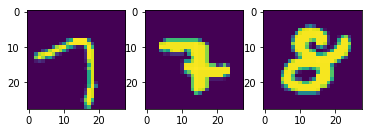

In [17]:
# show some sample images
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplot(131)
plt.imshow(mnist_train_images_5_9[17].reshape(28,28))
plt.subplot(132)
plt.imshow(mnist_valid_images_5_9[1031].reshape(28,28))
plt.subplot(133)
plt.imshow(mnist_test_images_5_9[3999].reshape(28,28))

Build a new DNN to classify digits 5 to 9 using  all 5 pretained hidden layers of the previous batch normalization model

In [18]:
# Build a new DNN to classify digits 5 to 9 using pretained hidden layers of the previous batch normalization model
from functools import partial
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

units = 100
n_outputs = 5
n_inputs = 28 * 28 #MNIST

tf.reset_default_graph()

X = tf.placeholder(tf.float32,shape=(None,n_inputs),name='X')
y = tf.placeholder(tf.int64,shape=(None),name='y')

with tf.name_scope('dnn'):
    he_init = tf.contrib.layers.variance_scaling_initializer()
    my_hidden_layer = partial(tf.layers.dense,kernel_initializer=he_init,activation=tf.nn.elu,units=units)
    
    hidden1 = my_hidden_layer(X,name='hidden1')
    hidden2 = my_hidden_layer(hidden1,name='hidden2')
    hidden3 = my_hidden_layer(hidden2,name='hidden3')
    hidden4 = my_hidden_layer(hidden3,name='hidden4')
    hidden5 = my_hidden_layer(hidden4,name='hidden5')
    logits = tf.layers.dense(hidden5,n_outputs,name='logits')
    
    #define variables to save and restore
    reuse_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope="hidden[12345]")
    reuse_vars_dict = dict([(var.op.name,var) for var in reuse_vars])
    #print(reuse_vars_dict)
    original_saver = tf.train.Saver(reuse_vars_dict)
    
    #define variables to train
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope='logits')
    
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=y)
    loss = tf.reduce_mean(xentropy,name='loss')
    
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
    training_op = optimizer.minimize(loss,name='training_op',var_list=train_vars)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits,y,1)
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32),name='eval')
    
init = tf.global_variables_initializer()
new_saver = tf.train.Saver()
valid_accuracy = tf.placeholder(tf.float32,shape=())
valid_summary = tf.summary.scalar('valid_accuracy',valid_accuracy)
summary_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())   

In [19]:
#execution phase
max_epoch_without_valid_improve = 20 # stop training if validation accuracy does not improve in five successive epochs
batch_size = 50
global_step_count = 0
epoch_count = 0
best_accu_valid = 0

with tf.Session() as sess:
    init.run()
    original_saver.restore(sess,'./model1_final.ckpt')
    hidden5_outputs = sess.run(hidden5,feed_dict={X:mnist_train_images_5_9})
    
    while epoch_count < max_epoch_without_valid_improve:
        shuffled_idx = np.random.permutation(hidden5_outputs.shape[0])
        hidden5_batches = np.array_split(hidden5_outputs[shuffled_idx],batch_size)
        y_batches = np.array_split(mnist_train_labels_5_9[shuffled_idx],batch_size)
        
        for hidden5_batch,y_batch in zip(hidden5_batches,y_batches):
            sess.run(training_op,feed_dict={hidden5:hidden5_batch,y:y_batch})
            global_step_count += 1
        accu_train = accuracy.eval(feed_dict={hidden5:hidden5_batch,y:y_batch})
        accu_valid = accuracy.eval(feed_dict={X:mnist_valid_images_5_9,y:mnist_valid_labels_5_9})  
        if accu_valid > best_accu_valid:
            best_accu_valid = accu_valid
            epoch_count = 0
        else:
            epoch_count += 1
        summary_str = valid_summary.eval(feed_dict={valid_accuracy:accu_valid})
        summary_writer.add_summary(summary_str, global_step_count)
        new_saver.save(sess,'./model4.ckpt')
        print(global_step_count,'Training Accuracy:',accu_train,'Validation Accuracy:',accu_valid)
    
    saver.save(sess,'./model4_final.ckpt')
        

summary_writer.flush()
summary_writer.close()

INFO:tensorflow:Restoring parameters from ./model1_final.ckpt
50 Training Accuracy: 0.4 Validation Accuracy: 0.473792
100 Training Accuracy: 0.5 Validation Accuracy: 0.603604
150 Training Accuracy: 0.4 Validation Accuracy: 0.665438
200 Training Accuracy: 0.7 Validation Accuracy: 0.701474
250 Training Accuracy: 0.8 Validation Accuracy: 0.716626
300 Training Accuracy: 0.8 Validation Accuracy: 0.744472
350 Training Accuracy: 0.7 Validation Accuracy: 0.753071
400 Training Accuracy: 0.8 Validation Accuracy: 0.768632
450 Training Accuracy: 0.9 Validation Accuracy: 0.77846
500 Training Accuracy: 0.8 Validation Accuracy: 0.785422
550 Training Accuracy: 0.9 Validation Accuracy: 0.79484
600 Training Accuracy: 1.0 Validation Accuracy: 0.798935
650 Training Accuracy: 0.8 Validation Accuracy: 0.80344
700 Training Accuracy: 0.8 Validation Accuracy: 0.802621
750 Training Accuracy: 0.8 Validation Accuracy: 0.810401
800 Training Accuracy: 1.0 Validation Accuracy: 0.818591
850 Training Accuracy: 0.8 Val

In [20]:
# Test accuracy of batch normalization and dropout model on test data
with tf.Session() as sess:
    saver.restore(sess,'./model4_final.ckpt')
    accu_test = accuracy.eval(feed_dict={X:mnist_test_images_5_9,y:mnist_test_labels_5_9})  
    print('Test Accuracy:',accu_test)

INFO:tensorflow:Restoring parameters from ./model4_final.ckpt
Test Accuracy: 0.860934


In [21]:
# do some predictions on the test data using batch normalization and dropout model
with tf.Session() as sess:
    saver.restore(sess,'./model4_final.ckpt')
    label_pred = np.argmax(sess.run(logits,feed_dict={X:mnist_test_images_5_9[2920:2925]}),axis=1) + 5
    
print('Prediction:',label_pred)
print('Target:',mnist_test_labels_5_9[2920:2925] + 5) 

INFO:tensorflow:Restoring parameters from ./model4_final.ckpt
Prediction: [6 9 7 9 6]
Target: [6 9 7 9 6]


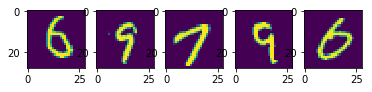

In [22]:
#show images corresponding to predicted digits
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplot(151)
plt.imshow(mnist_test_images_5_9[2920].reshape(28,28))
plt.subplot(152)
plt.imshow(mnist_test_images_5_9[2921].reshape(28,28))
plt.subplot(153)
plt.imshow(mnist_test_images_5_9[2922].reshape(28,28))
plt.subplot(154)
plt.imshow(mnist_test_images_5_9[2923].reshape(28,28))
plt.subplot(155)
plt.imshow(mnist_test_images_5_9[2924].reshape(28,28))
plt.show()

Build a new DNN to classify digits 5 to 9 using first 4 pretained hidden layers of the previous batch normalization model (model1)

In [23]:
from functools import partial
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

units = 100
n_outputs = 5
n_inputs = 28 * 28 #MNIST

tf.reset_default_graph()

X = tf.placeholder(tf.float32,shape=(None,n_inputs),name='X')
y = tf.placeholder(tf.int64,shape=(None),name='y')

with tf.name_scope('dnn'):
    he_init = tf.contrib.layers.variance_scaling_initializer()
    my_hidden_layer = partial(tf.layers.dense,kernel_initializer=he_init,activation=tf.nn.elu,units=units)
    
    hidden1 = my_hidden_layer(X,name='hidden1')
    hidden2 = my_hidden_layer(hidden1,name='hidden2')
    hidden3 = my_hidden_layer(hidden2,name='hidden3')
    hidden4 = my_hidden_layer(hidden3,name='hidden4')
    hidden5 = my_hidden_layer(hidden4,name='hidden5')
    logits = tf.layers.dense(hidden5,n_outputs,name='logits')
    
    #define variables to save and restore
    reuse_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope="hidden[1234]")
    reuse_vars_dict = dict([(var.op.name,var) for var in reuse_vars])
    #print(reuse_vars_dict)
    original_saver = tf.train.Saver(reuse_vars_dict)
    
    #define variables to train
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope='hidden[5]|logits')
    
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=y)
    loss = tf.reduce_mean(xentropy,name='loss')
    
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
    training_op = optimizer.minimize(loss,name='training_op',var_list=train_vars)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits,y,1)
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32),name='eval')
    
init = tf.global_variables_initializer()
new_saver = tf.train.Saver()
valid_accuracy = tf.placeholder(tf.float32,shape=())
valid_summary = tf.summary.scalar('valid_accuracy',valid_accuracy)
summary_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())   

In [24]:
#execution phase
max_epoch_without_valid_improve = 20 # stop training if validation accuracy does not improve in five successive epochs
batch_size = 50
global_step_count = 0
epoch_count = 0
best_accu_valid = 0

with tf.Session() as sess:
    init.run()
    original_saver.restore(sess,'./model1_final.ckpt')
    hidden4_outputs = sess.run(hidden4,feed_dict={X:mnist_train_images_5_9})
    
    while epoch_count < max_epoch_without_valid_improve:
        shuffled_idx = np.random.permutation(hidden4_outputs.shape[0])
        hidden4_batches = np.array_split(hidden4_outputs[shuffled_idx],batch_size)
        y_batches = np.array_split(mnist_train_labels_5_9[shuffled_idx],batch_size)
        
        for hidden4_batch,y_batch in zip(hidden4_batches,y_batches):
            sess.run(training_op,feed_dict={hidden4:hidden4_batch,y:y_batch})
            global_step_count += 1
        accu_train = accuracy.eval(feed_dict={hidden4:hidden4_batch,y:y_batch})
        accu_valid = accuracy.eval(feed_dict={X:mnist_valid_images_5_9,y:mnist_valid_labels_5_9})  
        if accu_valid > best_accu_valid:
            best_accu_valid = accu_valid
            epoch_count = 0
        else:
            epoch_count += 1
        summary_str = valid_summary.eval(feed_dict={valid_accuracy:accu_valid})
        summary_writer.add_summary(summary_str, global_step_count)
        new_saver.save(sess,'./model5.ckpt')
        print(global_step_count,'Training Accuracy:',accu_train,'Validation Accuracy:',accu_valid)
    
    saver.save(sess,'./model5_final.ckpt')
        

summary_writer.flush()
summary_writer.close()

INFO:tensorflow:Restoring parameters from ./model1_final.ckpt
50 Training Accuracy: 0.8 Validation Accuracy: 0.75389
100 Training Accuracy: 0.8 Validation Accuracy: 0.803849
150 Training Accuracy: 0.9 Validation Accuracy: 0.820229
200 Training Accuracy: 1.0 Validation Accuracy: 0.834152
250 Training Accuracy: 0.9 Validation Accuracy: 0.846437
300 Training Accuracy: 1.0 Validation Accuracy: 0.863227
350 Training Accuracy: 1.0 Validation Accuracy: 0.864455
400 Training Accuracy: 1.0 Validation Accuracy: 0.866912
450 Training Accuracy: 1.0 Validation Accuracy: 0.871007
500 Training Accuracy: 0.9 Validation Accuracy: 0.875512
550 Training Accuracy: 1.0 Validation Accuracy: 0.864046
600 Training Accuracy: 1.0 Validation Accuracy: 0.87674
650 Training Accuracy: 1.0 Validation Accuracy: 0.872236
700 Training Accuracy: 1.0 Validation Accuracy: 0.872645
750 Training Accuracy: 1.0 Validation Accuracy: 0.868141
800 Training Accuracy: 1.0 Validation Accuracy: 0.871417
850 Training Accuracy: 1.0 Va

In [25]:
# Test accuracy of batch normalization and dropout model on test data
with tf.Session() as sess:
    saver.restore(sess,'./model5_final.ckpt')
    accu_test = accuracy.eval(feed_dict={X:mnist_test_images_5_9,y:mnist_test_labels_5_9})  
    print('Test Accuracy:',accu_test)

INFO:tensorflow:Restoring parameters from ./model5_final.ckpt
Test Accuracy: 0.882946


In [26]:
# do some predictions on the test data using batch normalization and dropout model
with tf.Session() as sess:
    saver.restore(sess,'./model5_final.ckpt')
    label_pred = np.argmax(sess.run(logits,feed_dict={X:mnist_test_images_5_9[2920:2925]}),axis=1) + 5
    
print('Prediction:',label_pred)
print('Target:',mnist_test_labels_5_9[2920:2925] + 5) 

INFO:tensorflow:Restoring parameters from ./model5_final.ckpt
Prediction: [6 9 7 9 6]
Target: [6 9 7 9 6]


Build a new DNN to classify digits 5 to 9 using first 2 pretained hidden layers of the previous batch normalization model (model1)

In [27]:
from functools import partial
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

units = 100
n_outputs = 5
n_inputs = 28 * 28 #MNIST

tf.reset_default_graph()

X = tf.placeholder(tf.float32,shape=(None,n_inputs),name='X')
y = tf.placeholder(tf.int64,shape=(None),name='y')

with tf.name_scope('dnn'):
    he_init = tf.contrib.layers.variance_scaling_initializer()
    my_hidden_layer = partial(tf.layers.dense,kernel_initializer=he_init,activation=tf.nn.elu,units=units)
    
    hidden1 = my_hidden_layer(X,name='hidden1')
    hidden2 = my_hidden_layer(hidden1,name='hidden2')
    hidden3 = my_hidden_layer(hidden2,name='hidden3')
    hidden4 = my_hidden_layer(hidden3,name='hidden4')
    hidden5 = my_hidden_layer(hidden4,name='hidden5')
    logits = tf.layers.dense(hidden5,n_outputs,name='logits')
    
    #define variables to save and restore
    reuse_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope="hidden[12]")
    reuse_vars_dict = dict([(var.op.name,var) for var in reuse_vars])
    #print(reuse_vars_dict)
    original_saver = tf.train.Saver(reuse_vars_dict)
    
    #define variables to train
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope='hidden[345]|logits')
    
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=y)
    loss = tf.reduce_mean(xentropy,name='loss')
    
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
    training_op = optimizer.minimize(loss,name='training_op',var_list=train_vars)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits,y,1)
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32),name='eval')
    
init = tf.global_variables_initializer()
new_saver = tf.train.Saver()
valid_accuracy = tf.placeholder(tf.float32,shape=())
valid_summary = tf.summary.scalar('valid_accuracy',valid_accuracy)
summary_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())   

In [28]:
#execution phase
max_epoch_without_valid_improve = 20 # stop training if validation accuracy does not improve in five successive epochs
batch_size = 50
global_step_count = 0
epoch_count = 0
best_accu_valid = 0

with tf.Session() as sess:
    init.run()
    original_saver.restore(sess,'./model1_final.ckpt')
    hidden2_outputs = sess.run(hidden2,feed_dict={X:mnist_train_images_5_9})
    
    while epoch_count < max_epoch_without_valid_improve:
        shuffled_idx = np.random.permutation(hidden2_outputs.shape[0])
        hidden2_batches = np.array_split(hidden2_outputs[shuffled_idx],batch_size)
        y_batches = np.array_split(mnist_train_labels_5_9[shuffled_idx],batch_size)
        
        for hidden2_batch,y_batch in zip(hidden2_batches,y_batches):
            sess.run(training_op,feed_dict={hidden2:hidden2_batch,y:y_batch})
            global_step_count += 1
        accu_train = accuracy.eval(feed_dict={hidden2:hidden2_batch,y:y_batch})
        accu_valid = accuracy.eval(feed_dict={X:mnist_valid_images_5_9,y:mnist_valid_labels_5_9})  
        if accu_valid > best_accu_valid:
            best_accu_valid = accu_valid
            epoch_count = 0
        else:
            epoch_count += 1
        summary_str = valid_summary.eval(feed_dict={valid_accuracy:accu_valid})
        summary_writer.add_summary(summary_str, global_step_count)
        new_saver.save(sess,'./model6.ckpt')
        print(global_step_count,'Training Accuracy:',accu_train,'Validation Accuracy:',accu_valid)
    
    saver.save(sess,'./model6_final.ckpt')
        

summary_writer.flush()
summary_writer.close()

INFO:tensorflow:Restoring parameters from ./model1_final.ckpt
50 Training Accuracy: 1.0 Validation Accuracy: 0.837428
100 Training Accuracy: 1.0 Validation Accuracy: 0.890254
150 Training Accuracy: 1.0 Validation Accuracy: 0.891073
200 Training Accuracy: 1.0 Validation Accuracy: 0.904177
250 Training Accuracy: 1.0 Validation Accuracy: 0.905405
300 Training Accuracy: 1.0 Validation Accuracy: 0.900491
350 Training Accuracy: 1.0 Validation Accuracy: 0.90991
400 Training Accuracy: 1.0 Validation Accuracy: 0.904996
450 Training Accuracy: 1.0 Validation Accuracy: 0.911548
500 Training Accuracy: 1.0 Validation Accuracy: 0.913595
550 Training Accuracy: 1.0 Validation Accuracy: 0.911957
600 Training Accuracy: 1.0 Validation Accuracy: 0.90991
650 Training Accuracy: 1.0 Validation Accuracy: 0.911957
700 Training Accuracy: 1.0 Validation Accuracy: 0.914824
750 Training Accuracy: 1.0 Validation Accuracy: 0.915233
800 Training Accuracy: 1.0 Validation Accuracy: 0.914414
850 Training Accuracy: 1.0 Va

In [29]:
# Test accuracy of batch normalization and dropout model on test data
with tf.Session() as sess:
    saver.restore(sess,'./model6_final.ckpt')
    accu_test = accuracy.eval(feed_dict={X:mnist_test_images_5_9,y:mnist_test_labels_5_9})  
    print('Test Accuracy:',accu_test)

INFO:tensorflow:Restoring parameters from ./model6_final.ckpt
Test Accuracy: 0.916684


In [30]:
# do some predictions on the test data using batch normalization and dropout model
with tf.Session() as sess:
    saver.restore(sess,'./model6_final.ckpt')
    label_pred = np.argmax(sess.run(logits,feed_dict={X:mnist_test_images_5_9[2920:2925]}),axis=1) + 5
    
print('Prediction:',label_pred)
print('Target:',mnist_test_labels_5_9[2920:2925] + 5) 

INFO:tensorflow:Restoring parameters from ./model6_final.ckpt
Prediction: [6 9 7 9 6]
Target: [6 9 7 9 6]


Try introducing **dropoot**

In [31]:
from functools import partial
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

units = 100
n_outputs = 5
n_inputs = 28 * 28 #MNIST

tf.reset_default_graph()

X = tf.placeholder(tf.float32,shape=(None,n_inputs),name='X')
y = tf.placeholder(tf.int64,shape=(None),name='y')
is_training = tf.placeholder(tf.bool,shape=(),name='is_training')
with tf.name_scope('dnn'):
    he_init = tf.contrib.layers.variance_scaling_initializer()
    my_hidden_layer12 = partial(tf.layers.dense,kernel_initializer=he_init,activation=tf.nn.elu,units=units)
    my_hidden_layer  = partial(tf.layers.dense,kernel_initializer=he_init,units=units)
    my_dropout = partial(tf.layers.dropout,rate=0.5,training=is_training)
    
    hidden1 = my_hidden_layer12(X,name='hidden1')
    hidden2 = my_hidden_layer12(hidden1,name='hidden2')
    bn2 = my_dropout(hidden2,name='bn2')
    hidden3 = my_hidden_layer(bn2,name='hidden3')
    bn3 = my_dropout(hidden3,name='bn3')
    hidden4 = my_hidden_layer(bn3,name='hidden4')
    bn4 = my_dropout(hidden4,name='bn4')
    hidden5 = my_hidden_layer(bn4,name='hidden5')
    bn5 = my_dropout(hidden5,name='bn5')
    logits = tf.layers.dense(bn5,n_outputs,name='logits')
    
    #define variables to save and restore
    reuse_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope="hidden[12]")
    reuse_vars_dict = dict([(var.op.name,var) for var in reuse_vars])
    #print(reuse_vars_dict)
    original_saver = tf.train.Saver(reuse_vars_dict)
    
    #define variables to train
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope='hidden[345]|logits')
    
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=y)
    loss = tf.reduce_mean(xentropy,name='loss')
    
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
    training_op = optimizer.minimize(loss,name='training_op',var_list=train_vars)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits,y,1)
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32),name='eval')
    
init = tf.global_variables_initializer()
new_saver = tf.train.Saver()
valid_accuracy = tf.placeholder(tf.float32,shape=())
valid_summary = tf.summary.scalar('valid_accuracy',valid_accuracy)
summary_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())   

In [32]:
#execution phase
max_epoch_without_valid_improve = 20 # stop training if validation accuracy does not improve in five successive epochs
batch_size = 50
global_step_count = 0
epoch_count = 0
best_accu_valid = 0

with tf.Session() as sess:
    init.run()
    original_saver.restore(sess,'./model1_final.ckpt')
    hidden2_outputs = sess.run(hidden2,feed_dict={X:mnist_train_images_5_9})
    
    while epoch_count < max_epoch_without_valid_improve:
        shuffled_idx = np.random.permutation(hidden2_outputs.shape[0])
        hidden2_batches = np.array_split(hidden2_outputs[shuffled_idx],batch_size)
        y_batches = np.array_split(mnist_train_labels_5_9[shuffled_idx],batch_size)
        
        for hidden2_batch,y_batch in zip(hidden2_batches,y_batches):
            sess.run(training_op,feed_dict={is_training:True,hidden2:hidden2_batch,y:y_batch})
            global_step_count += 1
        accu_train = accuracy.eval(feed_dict={is_training:False,hidden2:hidden2_batch,y:y_batch})
        accu_valid = accuracy.eval(feed_dict={is_training:False,X:mnist_valid_images_5_9,y:mnist_valid_labels_5_9})  
        if accu_valid > best_accu_valid:
            best_accu_valid = accu_valid
            epoch_count = 0
        else:
            epoch_count += 1
        summary_str = valid_summary.eval(feed_dict={valid_accuracy:accu_valid})
        summary_writer.add_summary(summary_str, global_step_count)
        new_saver.save(sess,'./model7.ckpt')
        print(global_step_count,'Training Accuracy:',accu_train,'Validation Accuracy:',accu_valid)
    
    saver.save(sess,'./model7_final.ckpt')
        

summary_writer.flush()
summary_writer.close()

INFO:tensorflow:Restoring parameters from ./model1_final.ckpt
50 Training Accuracy: 0.6 Validation Accuracy: 0.6724
100 Training Accuracy: 1.0 Validation Accuracy: 0.751433
150 Training Accuracy: 0.6 Validation Accuracy: 0.787469
200 Training Accuracy: 0.6 Validation Accuracy: 0.798526
250 Training Accuracy: 0.9 Validation Accuracy: 0.799754
300 Training Accuracy: 0.8 Validation Accuracy: 0.816953
350 Training Accuracy: 0.9 Validation Accuracy: 0.801802
400 Training Accuracy: 0.9 Validation Accuracy: 0.823096
450 Training Accuracy: 1.0 Validation Accuracy: 0.825962
500 Training Accuracy: 0.9 Validation Accuracy: 0.846437
550 Training Accuracy: 0.9 Validation Accuracy: 0.835381
600 Training Accuracy: 1.0 Validation Accuracy: 0.821867
650 Training Accuracy: 0.8 Validation Accuracy: 0.821867
700 Training Accuracy: 0.8 Validation Accuracy: 0.823505
750 Training Accuracy: 0.9 Validation Accuracy: 0.833333
800 Training Accuracy: 0.9 Validation Accuracy: 0.843571
850 Training Accuracy: 0.9 Va

In [33]:
# Test accuracy of batch normalization and dropout model on test data
with tf.Session() as sess:
    saver.restore(sess,'./model7_final.ckpt')
    accu_test = accuracy.eval(feed_dict={is_training:False,X:mnist_test_images_5_9,y:mnist_test_labels_5_9})  
    print('Test Accuracy:',accu_test)

INFO:tensorflow:Restoring parameters from ./model7_final.ckpt
Test Accuracy: 0.866077


In [34]:
# do some predictions on the test data using batch normalization and dropout model
with tf.Session() as sess:
    saver.restore(sess,'./model7_final.ckpt')
    label_pred = np.argmax(sess.run(logits,feed_dict={is_training:False,X:mnist_test_images_5_9[2920:2925]}),axis=1) + 5
    
print('Prediction:',label_pred)
print('Target:',mnist_test_labels_5_9[2920:2925] + 5) 

INFO:tensorflow:Restoring parameters from ./model7_final.ckpt
Prediction: [6 9 7 9 6]
Target: [6 9 7 9 6]


Try training DNN to classify 5 to 9 **from scratch**

In [35]:
# Build a new DNN to classify digits 5 to 9 from scratch
from functools import partial
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

units = 100
n_outputs = 5
n_inputs = 28 * 28 #MNIST

tf.reset_default_graph()

X = tf.placeholder(tf.float32,shape=(None,n_inputs),name='X')
y = tf.placeholder(tf.int64,shape=(None),name='y')

with tf.name_scope('dnn'):
    he_init = tf.contrib.layers.variance_scaling_initializer()
    my_hidden_layer = partial(tf.layers.dense,kernel_initializer=he_init,activation=tf.nn.elu,units=units)
    
    hidden1 = my_hidden_layer(X,name='hidden1')
    hidden2 = my_hidden_layer(hidden1,name='hidden2')
    hidden3 = my_hidden_layer(hidden2,name='hidden3')
    hidden4 = my_hidden_layer(hidden3,name='hidden4')
    hidden5 = my_hidden_layer(hidden4,name='hidden5')
    logits = tf.layers.dense(hidden5,n_outputs,name='logits')
    
    
    
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=y)
    loss = tf.reduce_mean(xentropy,name='loss')
    
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
    training_op = optimizer.minimize(loss,name='training_op')
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits,y,1)
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32),name='eval')
    
init = tf.global_variables_initializer()
new_saver = tf.train.Saver()
valid_accuracy = tf.placeholder(tf.float32,shape=())
valid_summary = tf.summary.scalar('valid_accuracy',valid_accuracy)
summary_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())   

In [36]:
#execution phase
max_epoch_without_valid_improve = 20 # stop training if validation accuracy does not improve in five successive epochs
batch_size = 50
global_step_count = 0
epoch_count = 0
best_accu_valid = 0

with tf.Session() as sess:
    init.run()
    
    while epoch_count < max_epoch_without_valid_improve:
        shuffled_idx = np.random.permutation(mnist_train_images_5_9.shape[0])
        x_batches = np.array_split(mnist_train_images_5_9[shuffled_idx],batch_size)
        y_batches = np.array_split(mnist_train_labels_5_9[shuffled_idx],batch_size)
        
        for x_batch,y_batch in zip(x_batches,y_batches):
            sess.run(training_op,feed_dict={X:x_batch,y:y_batch})
            global_step_count += 1
        accu_train = accuracy.eval(feed_dict={X:x_batch,y:y_batch})
        accu_valid = accuracy.eval(feed_dict={X:mnist_valid_images_5_9,y:mnist_valid_labels_5_9})  
        if accu_valid > best_accu_valid:
            best_accu_valid = accu_valid
            epoch_count = 0
        else:
            epoch_count += 1
        summary_str = valid_summary.eval(feed_dict={valid_accuracy:accu_valid})
        summary_writer.add_summary(summary_str, global_step_count)
        new_saver.save(sess,'./model8.ckpt')
        print(global_step_count,'Training Accuracy:',accu_train,'Validation Accuracy:',accu_valid)
    
    saver.save(sess,'./model8_final.ckpt')
        

summary_writer.flush()
summary_writer.close()

50 Training Accuracy: 0.8 Validation Accuracy: 0.890254
100 Training Accuracy: 0.9 Validation Accuracy: 0.879607
150 Training Accuracy: 0.9 Validation Accuracy: 0.912776
200 Training Accuracy: 1.0 Validation Accuracy: 0.913595
250 Training Accuracy: 1.0 Validation Accuracy: 0.91769
300 Training Accuracy: 1.0 Validation Accuracy: 0.922195
350 Training Accuracy: 1.0 Validation Accuracy: 0.92629
400 Training Accuracy: 1.0 Validation Accuracy: 0.92588
450 Training Accuracy: 1.0 Validation Accuracy: 0.92588
500 Training Accuracy: 1.0 Validation Accuracy: 0.92629
550 Training Accuracy: 1.0 Validation Accuracy: 0.92588
600 Training Accuracy: 1.0 Validation Accuracy: 0.92588
650 Training Accuracy: 1.0 Validation Accuracy: 0.926699
700 Training Accuracy: 1.0 Validation Accuracy: 0.92588
750 Training Accuracy: 1.0 Validation Accuracy: 0.925471
800 Training Accuracy: 1.0 Validation Accuracy: 0.92588
850 Training Accuracy: 1.0 Validation Accuracy: 0.926699
900 Training Accuracy: 1.0 Validation Acc

In [37]:
# Test accuracy 
with tf.Session() as sess:
    saver.restore(sess,'./model8_final.ckpt')
    accu_test = accuracy.eval(feed_dict={X:mnist_test_images_5_9,y:mnist_test_labels_5_9})  
    print('Test Accuracy:',accu_test)

INFO:tensorflow:Restoring parameters from ./model8_final.ckpt
Test Accuracy: 0.922444


In [38]:
# do some predictions on the test data
with tf.Session() as sess:
    saver.restore(sess,'./model8_final.ckpt')
    label_pred = np.argmax(sess.run(logits,feed_dict={X:mnist_test_images_5_9[2920:2925]}),axis=1) + 5
    
print('Prediction:',label_pred)
print('Target:',mnist_test_labels_5_9[2920:2925] + 5) 

INFO:tensorflow:Restoring parameters from ./model8_final.ckpt
Prediction: [6 9 7 9 6]
Target: [6 9 7 9 6]


 ## Classifying digits 5 to 9 with the whole MNIST dataset

In [4]:
# preprocess data for training. Using digits 5 to 9
# shift labels such that  5->0,6->1,7->2,8->3,9->4
import numpy as np

#training set
train_index_5_9 = np.random.permutation(np.nonzero(mnist.train.labels >= 5)[0]) 
mnist_train_images_5_9 = mnist.train.images[train_index_5_9]
mnist_train_labels_5_9 = mnist.train.labels[train_index_5_9] - 5

#validation set
valid_index_5_9 = np.random.permutation(np.nonzero(mnist.validation.labels >= 5)[0]) 
mnist_valid_images_5_9 = mnist.validation.images[valid_index_5_9]
mnist_valid_labels_5_9 = mnist.validation.labels[valid_index_5_9] - 5

#test set
test_index_5_9 = np.random.permutation(np.nonzero(mnist.test.labels >= 5)[0]) 
mnist_test_images_5_9 = mnist.test.images[test_index_5_9]
mnist_test_labels_5_9 = mnist.test.labels[test_index_5_9] - 5

Let's now train

In [10]:
# Build a new DNN to classify digits 5 to 9 from scratch
from functools import partial
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

units = 100
n_outputs = 5
n_inputs = 28 * 28 #MNIST

tf.reset_default_graph()

X = tf.placeholder(tf.float32,shape=(None,n_inputs),name='X')
y = tf.placeholder(tf.int64,shape=(None),name='y')

with tf.name_scope('dnn'):
    he_init = tf.contrib.layers.variance_scaling_initializer()
    my_hidden_layer = partial(tf.layers.dense,kernel_initializer=he_init,activation=tf.nn.elu,units=units)
    
    hidden1 = my_hidden_layer(X,name='hidden1')
    hidden2 = my_hidden_layer(hidden1,name='hidden2')
    hidden3 = my_hidden_layer(hidden2,name='hidden3')
    hidden4 = my_hidden_layer(hidden3,name='hidden4')
    hidden5 = my_hidden_layer(hidden4,name='hidden5')
    logits = tf.layers.dense(hidden5,n_outputs,name='logits')
    
    
    
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=y)
    loss = tf.reduce_mean(xentropy,name='loss')
    
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
    training_op = optimizer.minimize(loss,name='training_op')
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits,y,1)
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32),name='eval')
    
init = tf.global_variables_initializer()
new_saver = tf.train.Saver()
valid_accuracy = tf.placeholder(tf.float32,shape=())
valid_summary = tf.summary.scalar('valid_accuracy',valid_accuracy)
summary_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())   

In [11]:
#execution phase
max_epoch_without_valid_improve = 20 # stop training if validation accuracy does not improve in five successive epochs
batch_size = 50
global_step_count = 0
epoch_count = 0
best_accu_valid = 0

with tf.Session() as sess:
    init.run()
    
    while epoch_count < max_epoch_without_valid_improve:
        shuffled_idx = np.random.permutation(mnist_train_images_5_9.shape[0])
        x_batches = np.array_split(mnist_train_images_5_9[shuffled_idx],batch_size)
        y_batches = np.array_split(mnist_train_labels_5_9[shuffled_idx],batch_size)
        
        for x_batch,y_batch in zip(x_batches,y_batches):
            sess.run(training_op,feed_dict={X:x_batch,y:y_batch})
            global_step_count += 1
        accu_train = accuracy.eval(feed_dict={X:x_batch,y:y_batch})
        accu_valid = accuracy.eval(feed_dict={X:mnist_valid_images_5_9,y:mnist_valid_labels_5_9})  
        if accu_valid > best_accu_valid:
            best_accu_valid = accu_valid
            epoch_count = 0
        else:
            epoch_count += 1
        summary_str = valid_summary.eval(feed_dict={valid_accuracy:accu_valid})
        summary_writer.add_summary(summary_str, global_step_count)
        new_saver.save(sess,'./model9.ckpt')
        print(global_step_count,'Training Accuracy:',accu_train,'Validation Accuracy:',accu_valid)
    
    new_saver.save(sess,'./model9_final.ckpt')
        

summary_writer.flush()
summary_writer.close()

50 Training Accuracy: 0.974026 Validation Accuracy: 0.958231
100 Training Accuracy: 0.975881 Validation Accuracy: 0.96683
150 Training Accuracy: 0.979592 Validation Accuracy: 0.969697
200 Training Accuracy: 0.972171 Validation Accuracy: 0.973792
250 Training Accuracy: 0.987013 Validation Accuracy: 0.973792
300 Training Accuracy: 0.988868 Validation Accuracy: 0.977068
350 Training Accuracy: 0.994434 Validation Accuracy: 0.978296
400 Training Accuracy: 0.992579 Validation Accuracy: 0.976249
450 Training Accuracy: 0.994434 Validation Accuracy: 0.982801
500 Training Accuracy: 0.998145 Validation Accuracy: 0.979934
550 Training Accuracy: 0.996289 Validation Accuracy: 0.983211
600 Training Accuracy: 0.998145 Validation Accuracy: 0.982801
650 Training Accuracy: 0.998145 Validation Accuracy: 0.984029
700 Training Accuracy: 0.998145 Validation Accuracy: 0.98362
750 Training Accuracy: 1.0 Validation Accuracy: 0.982801
800 Training Accuracy: 1.0 Validation Accuracy: 0.981163
850 Training Accuracy

In [12]:
# Test accuracy 
with tf.Session() as sess:
    new_saver.restore(sess,'./model9_final.ckpt')
    accu_test = accuracy.eval(feed_dict={X:mnist_test_images_5_9,y:mnist_test_labels_5_9})  
    print('Test Accuracy:',accu_test)

INFO:tensorflow:Restoring parameters from ./model9_final.ckpt
Test Accuracy: 0.98416


In [14]:
# do some predictions on the test data
with tf.Session() as sess:
    new_saver.restore(sess,'./model9_final.ckpt')
    label_pred = np.argmax(sess.run(logits,feed_dict={X:mnist_test_images_5_9[3873:3878]}),axis=1) + 5
    
print('Prediction:',label_pred)
print('Target:',mnist_test_labels_5_9[3873:3878] + 5) 

INFO:tensorflow:Restoring parameters from ./model9_final.ckpt
Prediction: [8 5 6 9 9]
Target: [8 5 6 9 9]


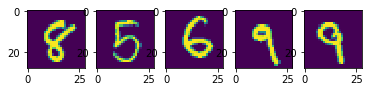

In [15]:
#show images corresponding to predicted digits
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplot(151)
plt.imshow(mnist_test_images_5_9[3873].reshape(28,28))
plt.subplot(152)
plt.imshow(mnist_test_images_5_9[3874].reshape(28,28))
plt.subplot(153)
plt.imshow(mnist_test_images_5_9[3875].reshape(28,28))
plt.subplot(154)
plt.imshow(mnist_test_images_5_9[3876].reshape(28,28))
plt.subplot(155)
plt.imshow(mnist_test_images_5_9[3877].reshape(28,28))
plt.show()